## 介绍

除了改进的transformer架构和海量无监督训练数据外，更好的解码方法也发挥了重要作用  
这篇博文简述了不同的解码策略，及如何使用流行的transformer库实现它们  
以下所有功能均可用于自回归语言生成。 自回归语言生成基于这样一个假设：一个 词序列 的概率分布可以分解为 条件下一个词分布的乘积
$$ P(w_{1:T} | W_0 ) = \prod_{t=1}^T P(w_{t} | w_{1: t-1}, W_0) \text{ ,with }  w_{1: 0} = \emptyset, $$

$W_0$ 是初始上下文词序列。 
词序列长度是 $T$ ，
EOS token是从 $P(w_{t} | w_{1: t-1}, W_{0})$中生成的。

自回归语言生成现在可用于 PyTorch 和 Tensorflow >= 2.0 中的 GPT2、XLNet、OpenAi-GPT、CTRL、TransfoXL、XLM、Bart、T5  
解码方法: 主要是Greedy search、Beam search、Top-K采样和 Top-p采样。  
快速安装transformers库并加载模型。 我们将在 Tensorflow 2.1 中使用 GPT2 进行演示，但 API 与 PyTorch 是一对一的

In [ ]:
import tensorflow as tf
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

## Greedy Search
贪心搜索 在每个时间步 t只选择概率最高的词作为下一个词：$w_t = argmax_{w}P(w | w_{1:t-1})$ 。 以下草图显示了贪婪搜索
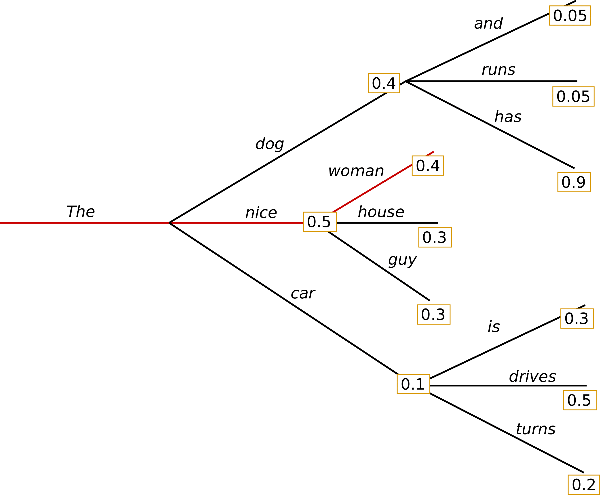

 从词$\text{"The"}$开始，算法贪婪地选择下一个概率最高的词$\text{"nice"}$等，这样最终生成的词序列为$\text{" The", "nice", "woman"}$  总概率为 $0.5 \times 0.4 = 0.2$

下面将 在上下文 $(\text{"I", "enjoy", "walking", "with", "my", "cute", "dog"})$ 上使用 GPT2 生成单词序列。 如何在transformers中使用贪婪搜索，如下所示:

In [ ]:
# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='tf')

# generate text until the output length (which includes the context length) reaches 50
greedy_output = model.generate(input_ids, max_length=50)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

根据上下文生成的词是合理的，但模型很快开始重复！ 这是语言生成中一个非常常见的问题，在greedy 和 beam search 中似乎更是如此

贪婪搜索的主要缺点是: 它会遗漏隐藏在低概率单词后面的高概率单词，如上面的草图所示：

具有 $0.9$ 高条件概率的单词 $\text{"has"}$ 隐藏在单词 $\text{"dog"}$ 后面， $\text{"dog"}$ 只有第二高的条件概率，因此贪婪搜索错过了 词序 $\text{"The"}, \text{"dog"}, \text{"has"}$。

可以用 beam search 来缓解这个问题！

## Beam search
Beam search 通过 在每个时间步保留最可能的num_beams假设 并最终选择 具有整体最高概率的假设 来降低 丢失隐藏的高概率单词序列的风险。 我们用 num_beams=2 来说明
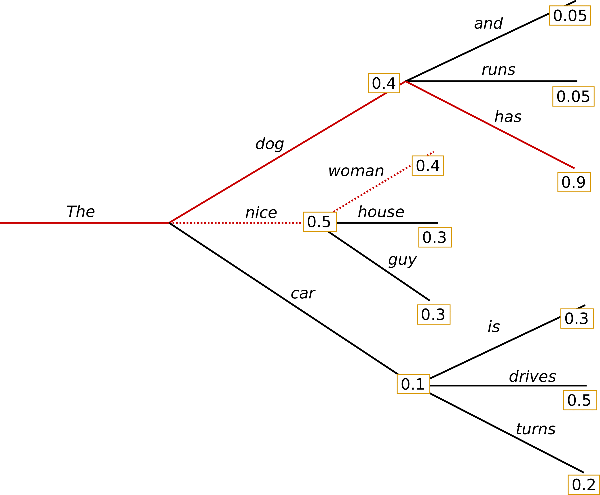

在时间步 $1$，除了最可能的假设 $\text{"The", "nice"}$，beam search 还会跟踪第二个最可能的假设 $\text{"The", "dog"}$。 

在时间步 $2$，beam search 发现词序列 $\text{"The", "dog", "has"}$ 的概率高于 $\text{"The", "nice", "women"}$，在示例中找到了最可能的单词序列！

Beam search 总是会比greedy search找到一个概率更高的输出序列，但不能保证找到最可能的输出。

如何在 transformers 中使用beam search。 设置 num_beams > 1 和 early_stopping=True 以便在所有beam假设到达 EOS token时完成生成

In [ ]:
# activate beam search and early_stopping
beam_output = model.generate(
    input_ids,  
    max_length=50, 
    num_beams=5, 
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

虽然结果更流畅，但输出仍然包括相同单词序列的重复。 一个简单的补救措施是引入 n-grams（也就是 $n$ 个词的词序列）惩罚。 

最常见的 n-gram 惩罚是通过手动 将下一个可能创建的单词，如果已出现，其n-gram 的的概率设置为 $0$ 来确保没有 n-gram 出现两次。

通过设置 no_repeat_ngram_size=2 来尝试一下，这样 2-gram 就不会出现两次

In [ ]:
# set no_repeat_ngram_size to 2
beam_output = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    no_repeat_ngram_size=2, 
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

可以看到重复不再出现。 然而，必须谨慎使用 n-gram 惩罚。 一篇关于纽约市的文章不应该使用2-gram惩罚或其他方式，否则城市的名字只会在整个文本中出现一次！

beam search的另一个重要特性是 可以比较生成后的top beams，并选择最适合我们目的 的生成beam。

在transformers中，只需将参数 num_return_sequences 设置为 应返回的最高得分beams的数量。 确保 num_return_sequences <= num_beams！

In [ ]:
# set return_num_sequences > 1
beam_outputs = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    no_repeat_ngram_size=2, 
    num_return_sequences=5, 
    early_stopping=True
)

# now we have 3 output sequences
print("Output:\n" + 100 * '-')
for i, beam_output in enumerate(beam_outputs):
  print("{}: {}".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))

可以看出，五个beam假设 彼此之间仅略有不同

在开放式生成中，最近提出了为什么 beam search 可能不是最佳选择的几个原因：

- Beam search在 所需的生成长度可以猜到 的任务中非常有效，例如在机器翻译或摘要中。 但是对于开放式生成而言，情况并非如此，其中所需的输出长度可能会有很大差异，例如 对话和故事生成。

- 可以看到beam search严重受到重复生成的影响。 这在故事生成中用 n-gram 或其他惩罚 难以控制，因为在强制“不重复”和相同n-gram的重复循环之间找到一个好的权衡需要大量的微调。

- 高质量的人类语言不遵循高概率下一个单词的分布。 换句话说，作为人类，希望生成的文本能给我们带来惊喜，而不是 boring/可预测。 通过绘制概率图很好地展示了这一点，模型给出 人类文本 vs beam search的作用

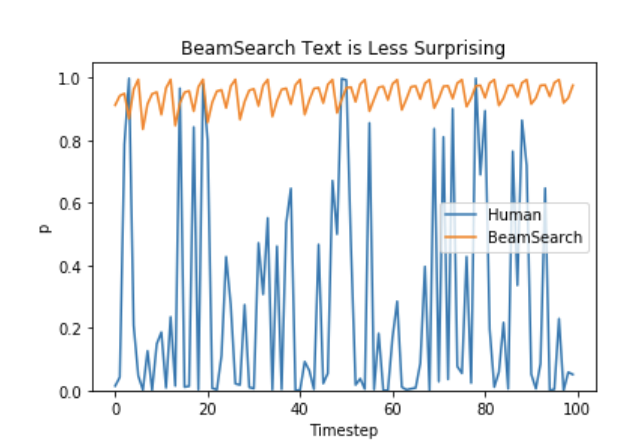

所以让我们停止boring 并引入一些随机性

## Sampling
采样意味着根据其条件概率分布随机选择下一个单词 $w_t$：$$w_t \sim P(w|w_{1:t-1})$$
以上面的例子为例，下图可视化了采样时的语言生成

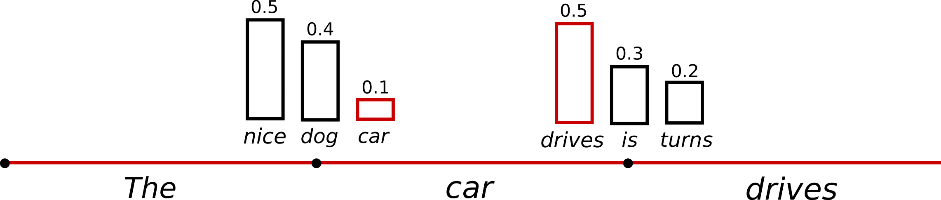

使用采样的语言生成不再是确定性的。 单词 $\text{"car"}$ 从条件概率分布 $P(w | \text{"The"})$ 中采样得到，然后$\text{"drives"}$ 从 $P(w | \text{"The"}, \text{"car"})$中采样得到。

在transformers中，设置 do_sample=True 并通过 top_k=0 停用 Top-K 采样。 

In [ ]:
# set seed to reproduce results. Feel free to change the seed though to get different results
tf.random.set_seed(0)

# activate sampling and deactivate top_k by setting top_k sampling to 0
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

文字看起来还不错，却不是很连贯。 3-grams "new hand sense"和"local batte harness"非常奇怪，听起来不像是人类写的。 这是采样单词序列时的大问题：模型经常产生不连贯的胡言乱语。

一个技巧是通过降低 softmax 的temperature，使分布 $P(w|w_{1:t-1})$ 更陡峭（增加 高概率词的可能性 并降低 低概率词的可能性)

将temperature应用于我们上面的示例,如下所示。

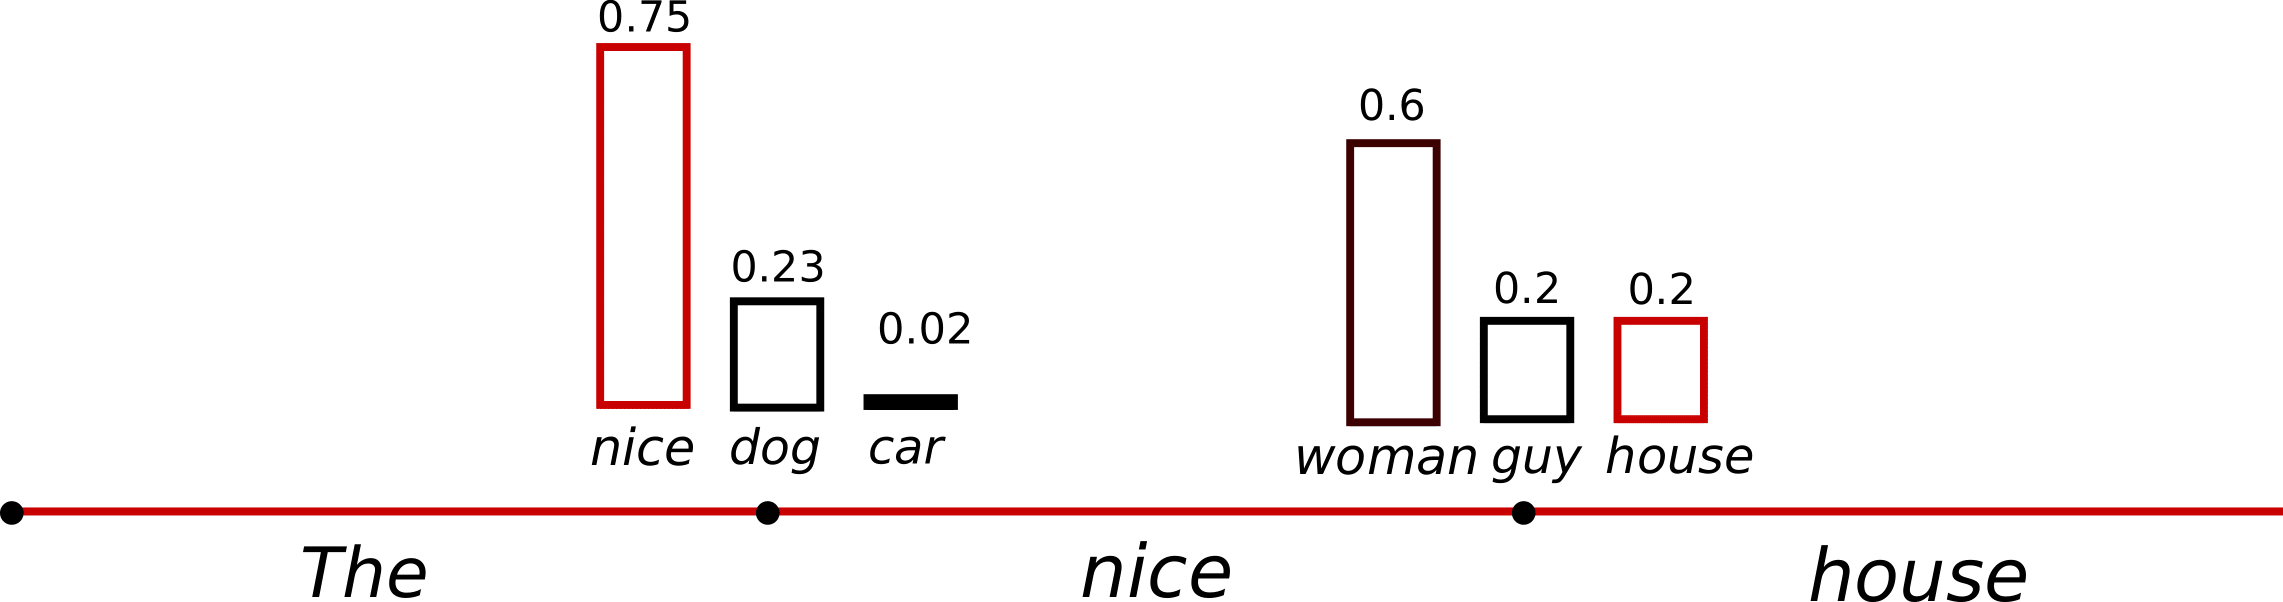

时间步 $t=1$ 的 条件下一个词分布 变得更加陡峭，几乎没有机会选择词 $\text{"car"}$。

让我们看看如何通过设置 temperature=0.7 来冷却 分布


In [ ]:
tf.random.set_seed(0)

# use temperature to decrease the sensitivity to low probability candidates
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_k=0, 
    temperature=0.7
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

奇怪的 n-gram 减少了，输出现在更加连贯了！ 应用temperature可以减少分布的随机性，当设置temperature $ \to 0$时，温度缩放采样等于greedy解码，并且会遇到与以前相同的问题

## Top-K Sampling
在 Top-K 采样中，K 个最有可能的 下一个词 被过滤出来，并且概率质量仅在这 K个 下一个词 之间重新分配。 GPT2采用了这种采样方案，这也是它在故事生成上取得成功的原因之一

将上述示例中 用于 两个采样步骤 的单词范围从 3 个单词扩展到 10 个单词，以更好地说明 Top-K 采样

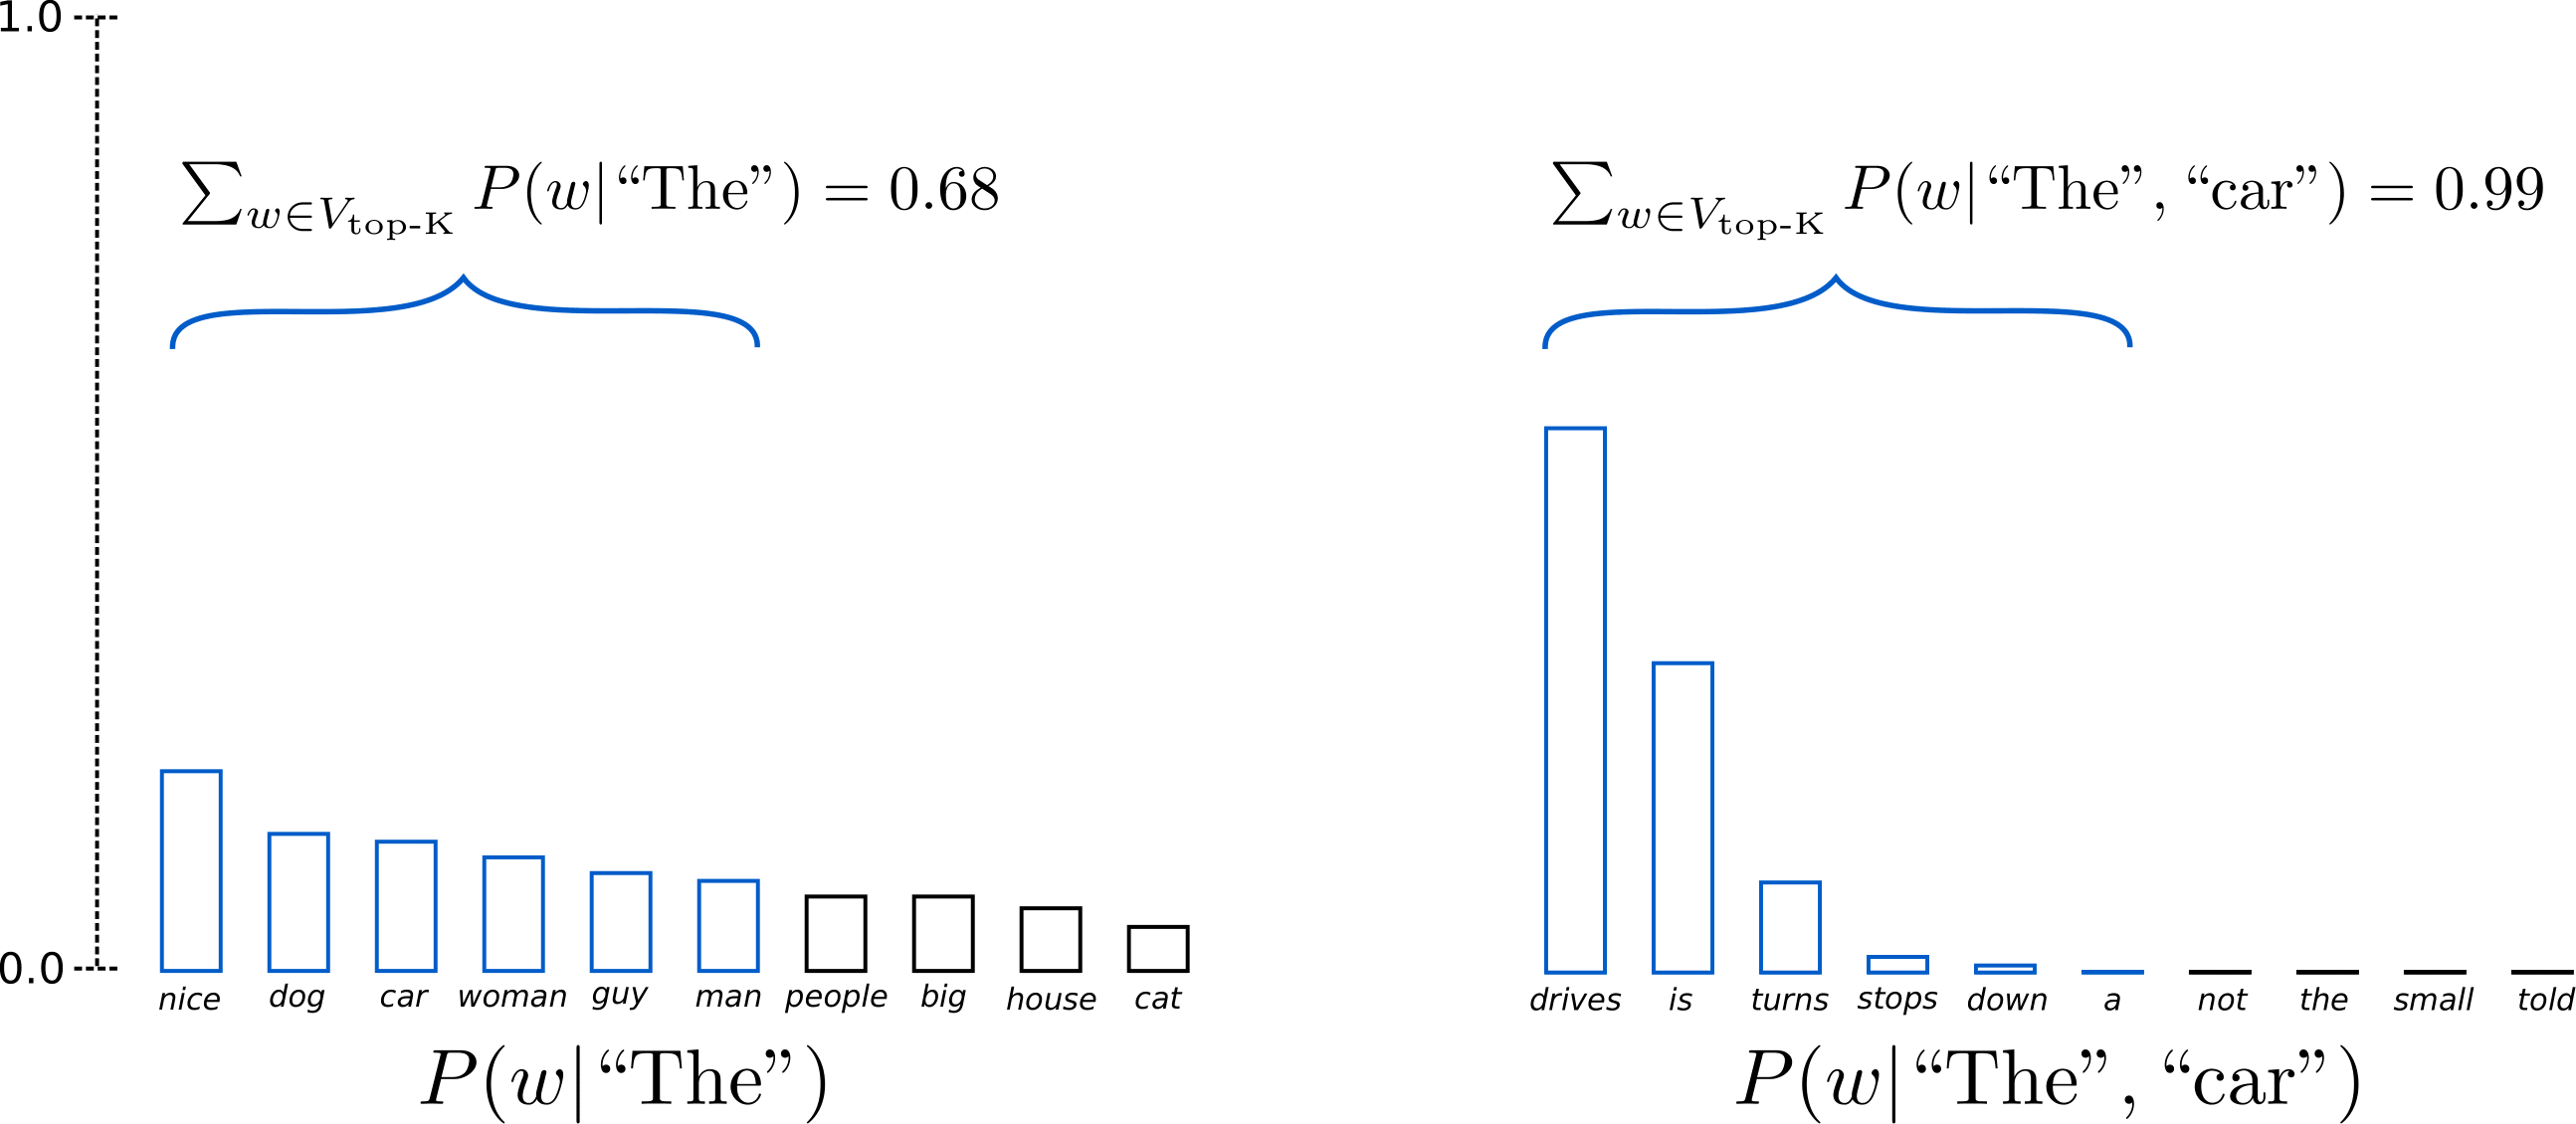

设置 $K = 6$ 后，在两个采样步骤中，我们将采样池限制为 6 个单词。 定义为 $V_{\text{top-K}}$ 的 6 个最有可能的单词 占第一步的全部概率质量的三分之二，几乎包括了第二步的全部概率质量。 尽管如此，我们看到它在第二个采样步骤中成功地消除了相当奇怪的候选者 $\text{"not", "the", "small", "told"}$

设置top_k=50来看看如何在库中使用Top-K

In [ ]:
tf.random.set_seed(0)

# set top_k to 50
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_k=50
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Top-K 采样的一个问题是 它不会动态调整 从下一个词概率分布 $P(w|w_{1:t-1})$ 中过滤出来的词 的数量。这可能会带来问题，因为某些单词可能是从非常陡峭的分布（上图中右侧的分布）中采样得到，而其他单词可能来自更平坦的分布（上图中左侧的分布）。

在步骤 $t=1$ 中，Top-K 消除了对 $\text{"people", "big", "house", "cat"}$ 进行采样的可能性，这似乎是合理的候选对象。

另一方面，在步骤 $t=2$ 中，该方法包括样本词池中可能不合适的词 $\text{"down", "a"}$。

因此，将样本池限制为固定大小 K 可能会危及模型：对陡峭分布产生胡言乱语，并限制模型对平坦分布的创造力。可以改用Top-p 或核采样

## Top-p (nucleus) sampling
在 Top-p 采样中，不是 从最可能的 K 个单词中采样，而是从 累积概率超过概率p的最小可能单词集中进行选择。 然后在这组单词之间重新分配概率质量。 这样，词集的大小（也就是词集的数量）可以根据下一个词的概率分布 动态增加和减少。
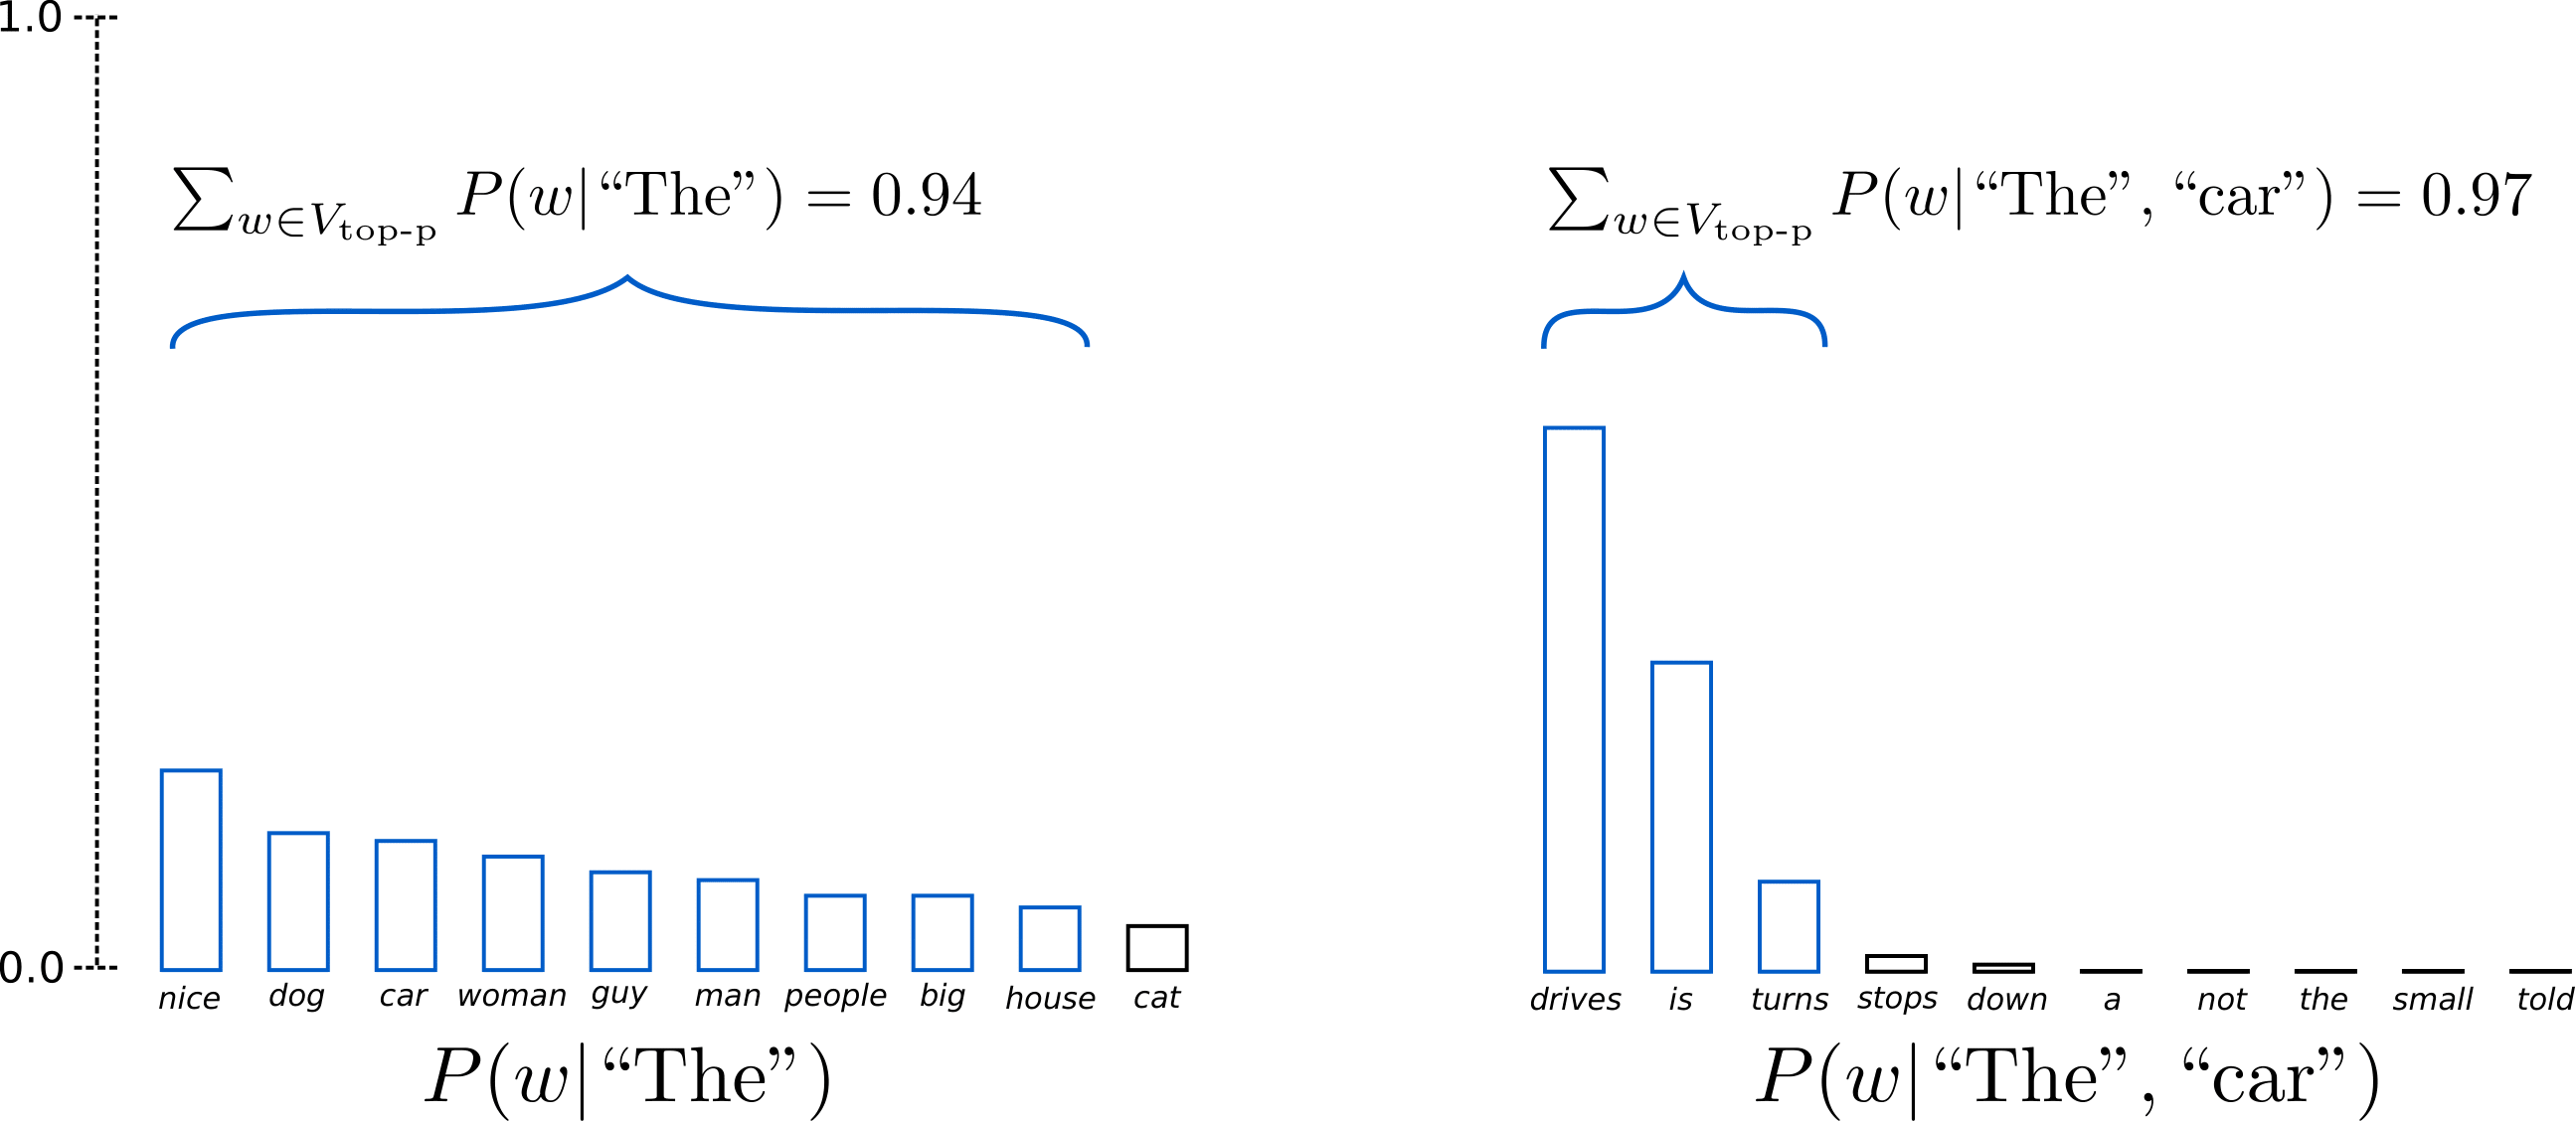

设置 $p=0.92$ 后，Top-p 采样会选择 一起超过 概率质量$p=92\%$ 的最小单词数，定义为 $V_{\text{top-p}}$。 在第一个示例中，这包括了 9 个最有可能的单词，而在第二个示例中，只需要选择前 3 个单词即可超过 92%。可以看出，它保留了广泛的单词，其中下一个单词可以说是不太可预测的，例如 $P(w | \text{"The"})$。当下一个词看起来更可预测时，只有几个词，例如 $P(w | \text{"The", "car"})$

通过设置 0 < top_p < 1 来激活 Top-p 采样

In [ ]:
tf.random.set_seed(0)

# deactivate top_k sampling and sample only from 92% most likely words
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_p=0.92, 
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

虽然从理论上讲，Top-p 似乎比 Top-K 更优雅，但两种方法在实践中都运行良好。 Top-p 也可以与 Top-K 结合使用，这样可以避开 排名非常低的词，同时允许一些动态选择。

为了得到多个独立采样的输出，可以再次设置参数 num_return_sequences > 1

In [ ]:
tf.random.set_seed(0)

# set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
sample_outputs = model.generate(
    input_ids,
    do_sample=True, 
    max_length=50, 
    top_k=50, 
    top_p=0.95, 
    num_return_sequences=3
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

## 结论
作为 ad-hoc 解码方法，top-p 和 top-K 采样似乎比传统的 greedy search 和 beam search 在开放式语言生成上 生成更流畅的文本。最近，有更多的证据表明greedy 和 beam search的明显缺陷——主要是生成重复的词序列——是由模型引起的（尤其是模型的训练方式），而不是解码方法。此外，看起来 top-K 和 top-p 采样也会产生重复的单词序列。

根据人工评估，在调整模型的训练目标时，beam search可以生成比 Top-p 采样更流畅的文本。

开放式语言生成是一个快速发展的研究领域，通常情况下，这里没有一刀切的方法，必须了解在特定用例中哪种方法最有效。

你可以在transfomers库中尝试所有不同的解码方法

## 附录
上面没有提到的 generate 方法有几个额外的参数。 这里简要解释它们：
- min_length: 用于强制模型在达到 min_length 之前不生成 EOS token（= 不完成句子）。 这在摘要中经常使用，如果用户想要更长的输出，通常会很有用。
- repeat_penalty: 用于惩罚 已经生成或属于上下文 的单词。可以非常有效地防止重复，但似乎对不同的模型和用例非常敏感，例如 请参阅 Github 上的[此讨论](https://github.com/huggingface/transformers/pull/2303)
- attention_mask 用于mask padded tokens
- pad_token_id, bos_token_id, eos_token_id：如果模型默认没有这些token，用户可以手动选择其他token id来表示

更多信息详见 generate方法[文档](https://huggingface.co/transformers/main_classes/model.html?highlight=generate#transformers.TFPreTrainedModel.generate)